In [1]:
#This is a test jupyter notebook!

#Load modules
from wrf_parallel import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [4]:
#Set domain/time

start_lat = -38; end_lat = -26; start_lon = 132; end_lon = 142
domain = [start_lat,end_lat,start_lon,end_lon]
time = [dt.datetime.strptime("2016092800","%Y%m%d%H"),dt.datetime.strptime("2016092806","%Y%m%d%H")]
t=3

In [5]:
#Load BARRA data

ta,temp1,hur,hgt,terrain,p,ps,wap,ua,va,uas,vas,tas,ta2d,wg10,lon,lat,date_list = \
        read_barra_fc(domain,time)

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/pint/quantity.py:1488: RuntimeWarning: divide by zero encountered in log
  return ufunc(*mobjs)


In [6]:
#Calculate other variables such as wet bulb and dew point

p_3d = np.moveaxis(np.tile(p,[ta.shape[2],ta.shape[3],1]),[0,1,2],[1,2,0]).astype(np.float32)
dp = get_dp(hur=hur[t], ta=ta[t], dp_mask = False)
sfc_ta = np.insert(ta[t], 0, tas[t], axis=0)
sfc_hgt = np.insert(hgt[t], 0, terrain, axis=0)
sfc_dp = np.insert(dp, 0, ta2d[t], axis=0)
sfc_p_3d = np.insert(p_3d, 0, ps[t], axis=0)
sfc_ua = np.insert(ua[t], 0, uas[t], axis=0)
sfc_va = np.insert(va[t], 0, vas[t], axis=0)
sfc_wap = np.insert(wap[t], 0, np.zeros(vas[t].shape), axis=0)
a,temp1,temp2 = np.meshgrid(np.arange(sfc_p_3d.shape[0]) , np.arange(sfc_p_3d.shape[1]),\
         np.arange(sfc_p_3d.shape[2]))
sort_inds = np.flip(np.lexsort([np.swapaxes(a,1,0),sfc_p_3d],axis=0), axis=0)
sfc_hgt = np.take_along_axis(sfc_hgt, sort_inds, axis=0)
sfc_dp = np.take_along_axis(sfc_dp, sort_inds, axis=0)
sfc_p_3d = np.take_along_axis(sfc_p_3d, sort_inds, axis=0)
sfc_ua = np.take_along_axis(sfc_ua, sort_inds, axis=0)
sfc_va = np.take_along_axis(sfc_va, sort_inds, axis=0)
sfc_ta = np.take_along_axis(sfc_ta, sort_inds, axis=0)
sfc_ta_unit = units.units.degC*sfc_ta
sfc_dp_unit = units.units.degC*sfc_dp
sfc_p_unit = units.units.hectopascals*sfc_p_3d
sfc_hur_unit = mpcalc.relative_humidity_from_dewpoint(sfc_ta_unit, sfc_dp_unit)*\
        100*units.units.percent
sfc_q_unit = mpcalc.mixing_ratio_from_relative_humidity(sfc_hur_unit,\
        sfc_ta_unit,sfc_p_unit)
sfc_theta_unit = mpcalc.potential_temperature(sfc_p_unit,sfc_ta_unit)
sfc_thetae_unit = mpcalc.equivalent_potential_temperature(sfc_p_unit,sfc_ta_unit,sfc_dp_unit)
sfc_q = np.array(sfc_q_unit)
sfc_hur = np.array(sfc_hur_unit)
#sfc_wb = sfc_ta - (1/3 * (sfc_ta - sfc_dp))
sfc_wb = np.array(wrf.wetbulb( sfc_p_3d*100, sfc_ta+273.15, sfc_q, units="degC"))

In [7]:
#Calculate mixed-layer parcel indices, based on avg sfc-100 hPa AGL layer parcel.

ml_inds = ((sfc_p_3d <= ps[t]) & (sfc_p_3d >= (ps[t] - 100)))
ml_p3d_avg = ( np.ma.masked_where(~ml_inds, sfc_p_3d).min(axis=0) + np.ma.masked_where(~ml_inds, sfc_p_3d).max(axis=0) ) / 2.
ml_hgt_avg = ( np.ma.masked_where(~ml_inds, sfc_hgt).min(axis=0) + np.ma.masked_where(~ml_inds, sfc_hgt).max(axis=0) ) / 2.
ml_ta_avg = trapz_int3d(sfc_ta, sfc_p_3d, ml_inds ).astype(np.float32)
ml_q_avg = trapz_int3d(sfc_q, sfc_p_3d, ml_inds ).astype(np.float32)
ml_ta_arr = np.insert(sfc_ta,0,ml_ta_avg,axis=0)
ml_q_arr = np.insert(sfc_q,0,ml_q_avg,axis=0)
ml_hgt_arr = np.insert(sfc_hgt,0,ml_hgt_avg,axis=0)
ml_p3d_arr = np.insert(sfc_p_3d,0,ml_p3d_avg,axis=0)
a,temp1,temp2 = np.meshgrid(np.arange(ml_p3d_arr.shape[0]) ,\
         np.arange(ml_p3d_arr.shape[1]), np.arange(ml_p3d_arr.shape[2]))
sort_inds = np.flipud(np.lexsort([np.swapaxes(a,1,0),ml_p3d_arr],axis=0))
ml_ta_arr = np.take_along_axis(ml_ta_arr, sort_inds, axis=0)
ml_p3d_arr = np.take_along_axis(ml_p3d_arr, sort_inds, axis=0)
ml_hgt_arr = np.take_along_axis(ml_hgt_arr, sort_inds, axis=0)
ml_q_arr = np.take_along_axis(ml_q_arr, sort_inds, axis=0)
cape3d_mlavg = wrf.cape_3d(ml_p3d_arr.astype(np.float64),\
        (ml_ta_arr + 273.15).astype(np.float64),\
        ml_q_arr.astype(np.float64),\
        ml_hgt_arr.astype(np.float64),terrain.astype(np.float64),\
        ps[t].astype(np.float64),False,meta=False, missing=0)
ml_cape = np.ma.masked_where(~((ml_ta_arr==ml_ta_avg) & (ml_p3d_arr==ml_p3d_avg)),\
        cape3d_mlavg.data[0]).max(axis=0).filled(0)
ml_cin = np.ma.masked_where(~((ml_ta_arr==ml_ta_avg) & (ml_p3d_arr==ml_p3d_avg)),\
        cape3d_mlavg.data[1]).max(axis=0).filled(0)
ml_lfc = np.ma.masked_where(~((ml_ta_arr==ml_ta_avg) & (ml_p3d_arr==ml_p3d_avg)),\
        cape3d_mlavg.data[2]).max(axis=0).filled(0)
ml_lcl = np.ma.masked_where(~((ml_ta_arr==ml_ta_avg) & (ml_p3d_arr==ml_p3d_avg)),\
        cape3d_mlavg.data[3]).max(axis=0).filled(0)
ml_el = np.ma.masked_where(~((ml_ta_arr==ml_ta_avg) & (ml_p3d_arr==ml_p3d_avg)),\
        cape3d_mlavg.data[4]).max(axis=0).filled(0)

In [8]:
#Get DCAPE

dcape, ddraft_temp = get_dcape(np.array(sfc_p_3d[np.concatenate([[1100], p]) >= 300]), \
                        sfc_ta[np.concatenate([[1100], p]) >= 300], \
                        sfc_q[np.concatenate([[1100], p]) >= 300], \
                        sfc_hgt[np.concatenate([[1100], p]) >= 300], \
                        np.array(p[p>=300]), ps[t])
sfc_thetae300 = sfc_thetae_unit[np.concatenate([[1100], p]) >= 300].data
sfc_p300 = sfc_p_3d[np.concatenate([[1100], p]) >= 300]
sfc_thetae300[(ps[t] - sfc_p300) > 400] = np.nan
sfc_thetae300[(sfc_p300 > ps[t])] = np.nan
#Calculate for all levels (sfc to 400 hPa agl), and then mask based on height agl 
dcape = np.nanargmin(sfc_thetae300, axis=0).choose(dcape)

/home/548/ab4502/working/ExtremeWind/SkewT/skewt/SkewT.py:1014: RuntimeWarning: All-NaN slice encountered
  ddraft_temp = nanmax(tparcel,axis=1)


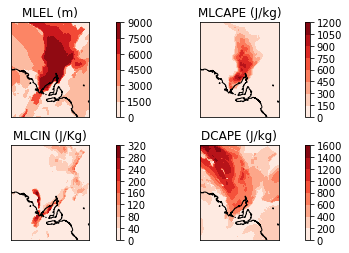

In [10]:
#Plot!
m = Basemap(llcrnrlon=132, llcrnrlat=-38, urcrnrlon=142, urcrnrlat=-26,projection="cyl",resolution="h")
x,y = np.meshgrid(lon,lat)
plt.subplot(221)
plt.contourf(x,y,ml_el,cmap=plt.get_cmap("Reds"));plt.colorbar();m.drawcoastlines();plt.title("MLEL (m)")
plt.subplot(222)
plt.contourf(x,y,ml_cape,cmap=plt.get_cmap("Reds"));plt.colorbar();m.drawcoastlines();plt.title("MLCAPE (J/kg)")
plt.subplot(223)
plt.contourf(x,y,ml_cin,cmap=plt.get_cmap("Reds"));plt.colorbar();m.drawcoastlines();plt.title("MLCIN (J/Kg)")
plt.subplot(224)
plt.contourf(x,y,dcape,cmap=plt.get_cmap("Reds"));plt.colorbar();m.drawcoastlines();plt.title("DCAPE (J/kg)")
plt.subplots_adjust(hspace=0.3, wspace=0.3)